In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
import os
from PIL import Image
from tqdm import tqdm

# Update this to your actual folder
data_dir = "/content/drive/MyDrive/food_vision_dataset"

# Target image size
IMG_SIZE = (224, 224)


In [4]:
import os
import random
import shutil
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

# Set parameters
data_dir = Path("/content/drive/MyDrive/food_vision_dataset")  # Replace with your actual dataset path
output_dir = Path("path/to/split_dataset")  # Where train/val/test will go
img_height = 224
img_width = 224
batch_size = 32
seed = 123

# Step 1: Get all image paths and labels
all_images = list(data_dir.rglob("*.jpg"))  # or *.png depending on your dataset
all_labels = [img.parent.name for img in all_images]

# Step 2: Split into train, val, test
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=seed)

val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)

# Step 3: Copy files into train/val/test directories
def copy_files(images, labels, subset):
    for img, label in zip(images, labels):
        dest_dir = output_dir / subset / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img, dest_dir / img.name)

copy_files(train_imgs, train_labels, "train")
copy_files(val_imgs, val_labels, "val")
copy_files(test_imgs, test_labels, "test")

# Step 4: Load datasets with image_dataset_from_directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / "train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / "val",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir / "test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed
)


Dataset split and copied to: /content/split_food_dataset


In [6]:
! /content/split_food_dataset

/bin/bash: line 1: /content/split_food_dataset: Is a directory


In [7]:
# ipython-input-5-73a2478098c4

# After splitting and copying, create the TensorFlow datasets

# Ensure output_dir is a string path for image_dataset_from_directory
output_dir_str = str(output_dir)

# Create training dataset
train_ds = image_dataset_from_directory(
    os.path.join(output_dir_str, "train"),
    labels='inferred',
    label_mode='int', # Use 'int' for sparse_categorical_crossentropy
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

# Create validation dataset
val_ds = image_dataset_from_directory(
    os.path.join(output_dir_str, "val"),
    labels='inferred',
    label_mode='int', # Use 'int' for sparse_categorical_crossentropy
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False # No need to shuffle validation data
)

# Create test dataset
test_ds = image_dataset_from_directory(
    os.path.join(output_dir_str, "test"),
    labels='inferred',
    label_mode='int', # Use 'int' for sparse_categorical_crossentropy
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False # No need to shuffle test data
)


# Naming the classes AFTER the datasets are created
class_names = train_ds.class_names
print("Classes:", class_names)

Found 1612 files belonging to 10 classes.
Found 345 files belonging to 10 classes.
Found 346 files belonging to 10 classes.
Classes: ['akara', 'banga_soup', 'egusi_soup', 'jollof_rice', 'moi_moi', 'nkwobi', 'okpa', 'suya', 'tuwo', 'yam_porridge']


In [5]:
# Naming the classes
class_names = train_ds.class_names
print("Classes:", class_names)

NameError: name 'train_ds' is not defined

In [10]:
import os

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))
            ])
            class_counts[class_name] = num_images

    # Print counts
    for class_name, count in sorted(class_counts.items()):
        print(f"{class_name}: {count} images")

# Run the count
count_images_per_class('/content/drive/MyDrive/food_vision_dataset')


akara: 265 images
banga_soup: 266 images
egusi_soup: 260 images
jollof_rice: 276 images
moi_moi: 244 images
nkwobi: 224 images
okpa: 250 images
suya: 229 images
tuwo: 245 images
yam_porridge: 243 images


In [11]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),


])

In [12]:
# ──────────────── 4. Build EfficientNetB3 Model ────────────────
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import models # Import models if not already imported

base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # freeze the convolutional base

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.Dense(128, activation='relu', name="dense_128")(x)
x = layers.Dropout(0.4, name="dropout")(x)
outputs = layers.Dense(len(class_names), activation='softmax', name="predictions")(x)

model = models.Model(inputs, outputs, name="food_vision_efficientnetb3")

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "food_vision_efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,981,561 (41.89 MB)

 Trainable params: 198,026 (773.54 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [13]:
#EarlyStopping & Learning Rate Scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


In [14]:
# Training the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)



Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 366s 7s/step - accuracy: 0.3976 - loss: 1.8003 - val_accuracy: 0.8000 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.7945 - loss: 0.7225 - val_accuracy: 0.8087 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 383s 6s/step - accuracy: 0.8218 - loss: 0.5637 - val_accuracy: 0.8261 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 356s 6s/step - accuracy: 0.8749 - loss: 0.4321 - val_accuracy: 0.8145 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 340s 6s/step - accuracy: 0.8955 - loss: 0.3207 - val_accuracy: 0.8377 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - accuracy: 0.9094 - loss: 0.3012 - val_accuracy: 0.8348 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9178 - loss: 0.2723
Epoch 7: Re

In [15]:
# Evaluating the model performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training Accuracy:", acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Training Loss:", loss[-1])
print("Validation Loss:", val_loss[-1])

Training Accuracy: 0.9547146558761597
Validation Accuracy: 0.843478262424469
Training Loss: 0.17017896473407745
Validation Loss: 0.537575900554657


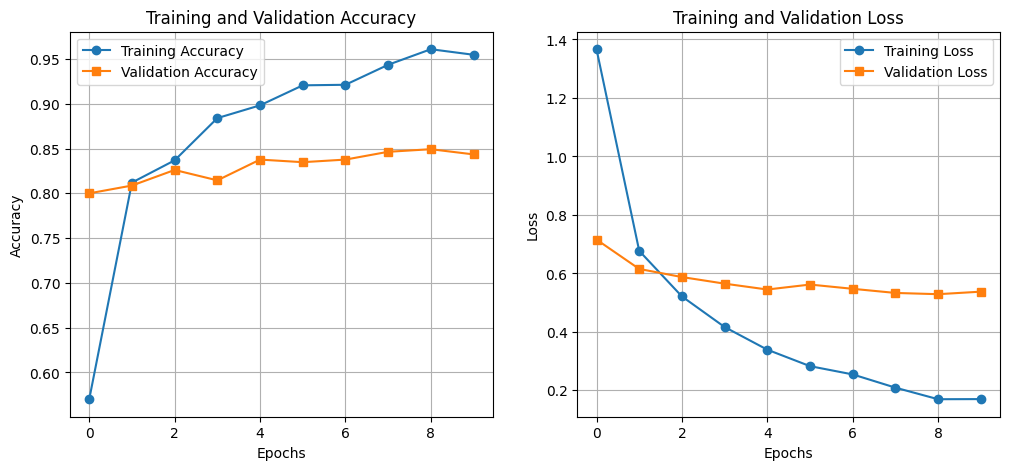

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy', marker='o')
plt.plot(range(10), val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss', marker='o')
plt.plot(range(10), val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()

plt.show()


In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.8540 - loss: 0.5041
Test Loss: 0.5746676921844482
Test Accuracy: 0.8410404920578003


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        36
           1       0.73      0.82      0.77        33
           2       0.86      0.83      0.85        36
           3       0.85      0.90      0.88        39
           4       0.76      0.91      0.83        34
           5       0.94      0.94      0.94        32
           6       0.81      0.58      0.68        36
           7       0.87      0.84      0.85        31
           8       0.88      0.86      0.87        35
           9       0.81      0.88      0

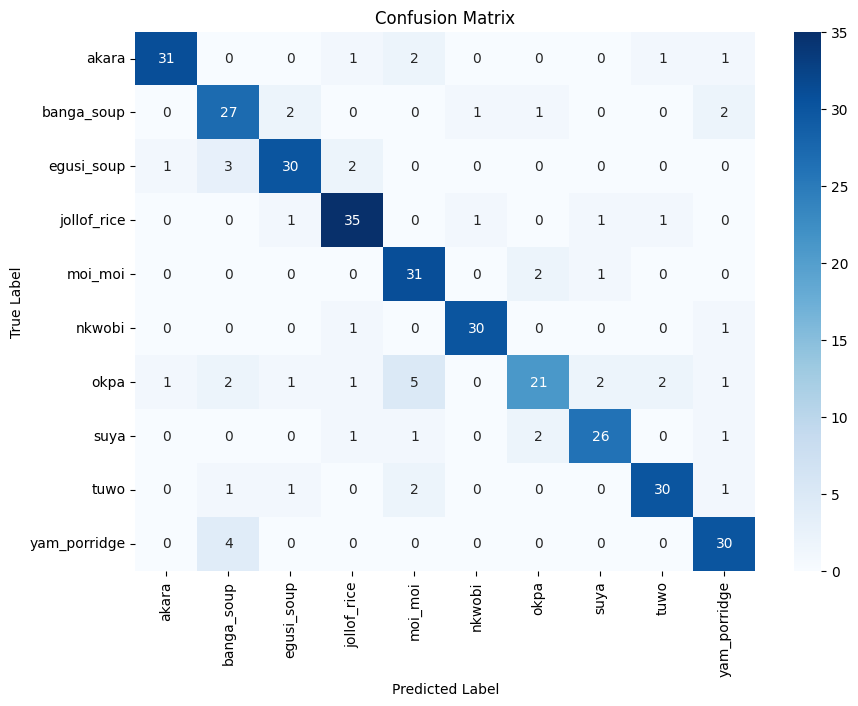

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=-1))  # Convert predictions to labels

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [22]:
model.save('/content/drive/MyDrive/food_vision_model.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


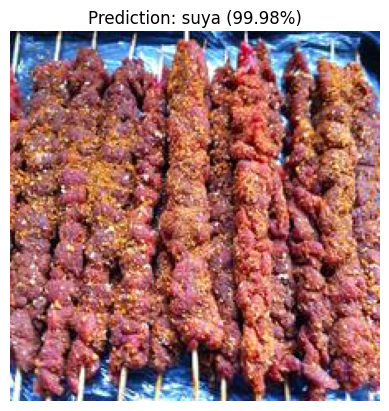

🍽️ Food: Suya
🌍 Ethnicity: Northern Nigeria (Hausa)
🥦 Ingredients: beef, suya spice mix, peanut powder, oil
🧪 Nutrients: Calories: 250 kcal, Carbs: 5g, Protein: 20g, Fat: 18g
❤️ Health Advice: High in protein; grilled for less fat than fried.
🌱 Diet Type: 🥩 Non-vegan


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# Load the trained model
model_path = '/content/drive/MyDrive/food_vision_model.keras'
model = tf.keras.models.load_model(model_path)



# Load food metadata from JSON
metadata_path = "/content/drive/MyDrive/food_vision_metadata.json"  # Update this!
with open(metadata_path, "r") as f:
    food_metadata = json.load(f)

class_names = list(food_info.keys())

# Function to load and prepare image
def load_and_prep_image(img_path, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Predict image
img_path = '/content/drive/MyDrive/000002.jpg'
img_array = load_and_prep_image(img_path)
pred = model.predict(img_array)[0]

# Get prediction and metadata
pred_class = class_names[np.argmax(pred)]
confidence = np.max(pred)
info = food_info[pred_class]

# Display result
plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
plt.title(f"Prediction: {pred_class} ({confidence:.2%})")
plt.axis("off")
plt.show()

# Display metadata
print(f"🍽️ Food: {pred_class.replace('_', ' ').title()}")
print(f"🌍 Ethnicity: {info['ethnicity']}")
print(f"🥦 Ingredients: {info['ingredients']}")
print(f"🧪 Nutrients: Calories: {info['nutrients']['Calories']} kcal, "
      f"Carbs: {info['nutrients']['Carbs']}g, "
      f"Protein: {info['nutrients']['Protein']}g, "
      f"Fat: {info['nutrients']['Fat']}g")
print(f"❤️ Health Advice: {info['health']}")
print(f"🌱 Diet Type: {info['diet']}")
